# El fijador de precios de productos (continuación)

Un modelo que puede estimar cuánto cuesta algo a partir de su descripción.

## Curación de datos, parte 2

Hoy ampliaremos nuestro conjunto de datos para que tenga una mayor cobertura y lo convertiremos en un excelente conjunto de datos para el entrenamiento.

El conjunto de datos está aquí:
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

Y la carpeta con todos los conjuntos de datos de productos está aquí:
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

## El conjunto de datos Lite

Este cuaderno es una alternativa a `day2.ipynb` que crea un conjunto de datos más pequeño solo para electrodomésticos, para mantener el entrenamiento rápido y los costos bajos. Es posible que deba actualizar los nombres de los cuadernos futuros para reflejar que ha creado el conjunto de datos "lite", no el conjunto de datos completo.

In [1]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [2]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in en HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
%matplotlib inline

## El código de ItemLoader

Mira en loaders.py: hay un código útil que nos hará la vida más fácil

## Ahora, a ESCALAR A LO GRANDE

Veamos todos los conjuntos de datos de todos los artículos que puede encontrar en una gran tienda minorista para el hogar: artículos eléctricos, electrónicos, de oficina y relacionados, pero no ropa, belleza ni libros.

In [5]:
dataset_names = [
    # "Automotive",
    # "Electronics",
    # "Office_Products",
    # "Tools_and_Home_Improvement",
    # "Cell_Phones_and_Accessories",
    # "Toys_and_Games",
x    # "Musical_Instruments",
]

In [6]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Cargando dataset Appliances


100%|███████████████████████████████████████████| 95/95 [00:09<00:00, 10.27it/s]


Completado Appliances con 28,625 datapoints en 0.2 mins


In [7]:
print(f"Un total de {len(items):,} items")

Un total de 28,625 items


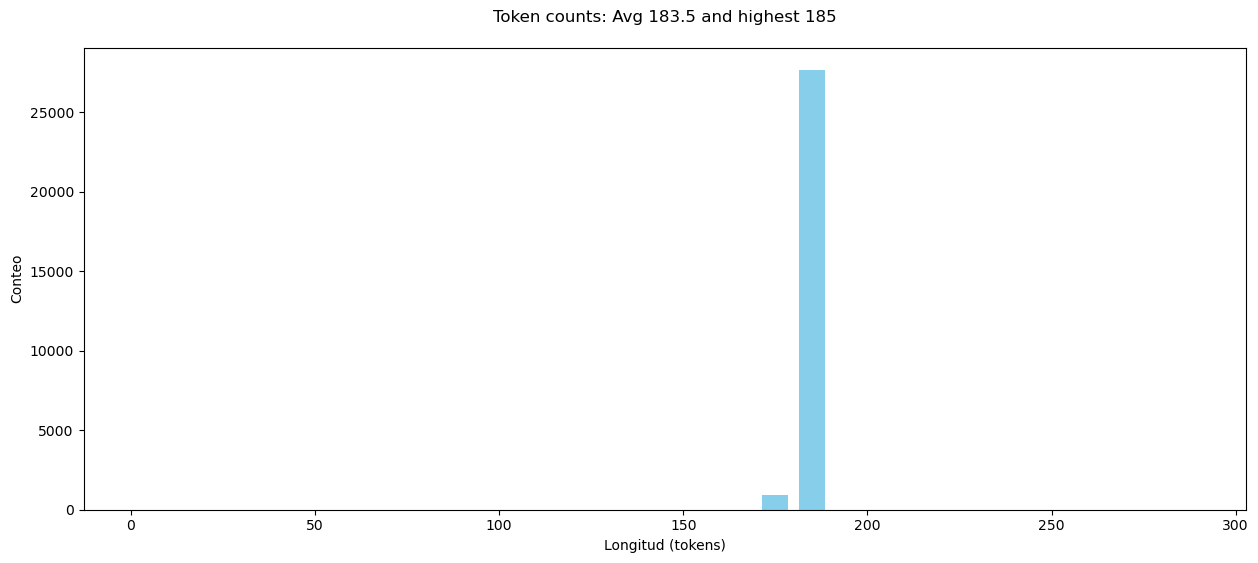

In [8]:
# Representamos nuevamente la distribución de los recuentos de tokens

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Longitud (tokens)')
plt.ylabel('Conteo')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

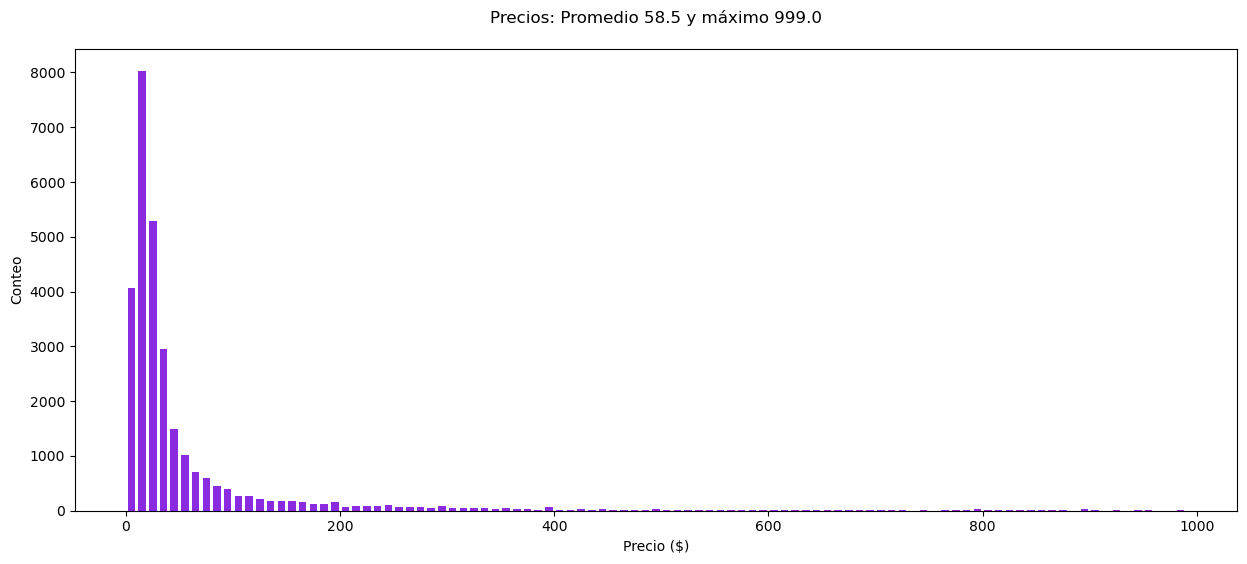

In [9]:
# Representamos la distribución de los precios

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Precios: Promedio {sum(prices)/len(prices):,.1f} y máximo {max(prices):,}\n")
plt.xlabel('Precio ($)')
plt.ylabel('Conteo')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

# ¡Conjunto de datos seleccionado!

Hemos creado un excelente conjunto de datos.

Hagamos algunas comprobaciones finales

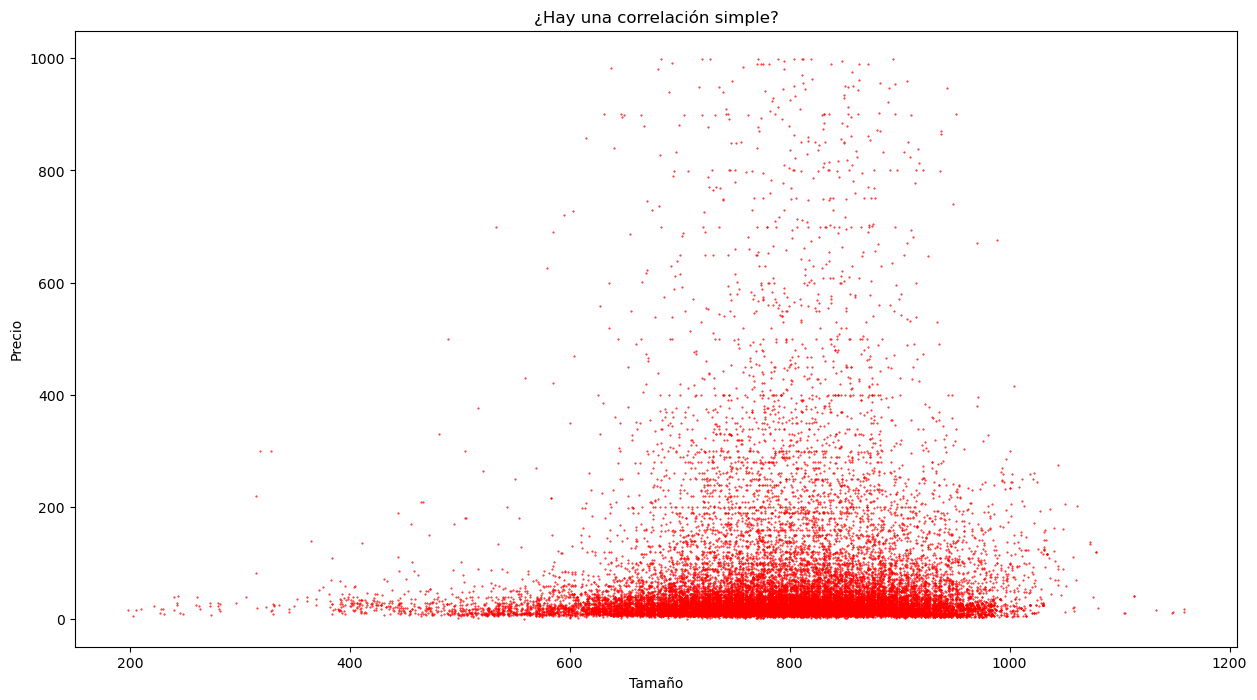

In [10]:
# ¿Cómo varía el precio según el número de caracteres del mensaje?

sample = items

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Creamos el scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Añadimos etiquetas y título
plt.xlabel('Tamaño')
plt.ylabel('Precio')
plt.title('¿Hay una correlación simple?')

# Representamos el gráfico
plt.show()

In [11]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [12]:
report(sample[50])

¿Cuánto cuesta esto redondeado al dólar más cercano?

285746 OR 285811 Washer Agitator Support And Dogs Compatible with Inglis, Whirlpool, Kenmore, Roper, Admiral
285746 OR 285811 Agitator support and dogs Washing machine agitator repair kit with a medium length cam Agitator support and dogs for two piece agitators.This kit should be used when the top part of the agitator is not moving properly but the bottom part is. Replaces Old Numbers 2744 285746 285811 Washer Agitator Repair Kit. This part works with the following brands Whirlpool, Roper, Admiral, Maytag, Hardwick, Jenn-Air, Estate, Magic Chef, Crosley, Inglis, Norge, Modern Maid, Amana, Kenmore

Price is $8.00
[11, 14594, 6518, 271, 7117, 374, 400, 23, 13, 410]
[',', ' Ken', 'more', '\n\n', 'Price', ' is', ' $', '8', '.', '00']


## Observación

Una característica interesante del tokenizador de Llama es que cada número del 1 al 999 se asigna a un token, de forma muy similar a lo que vimos con gpt-4o. No ocurre lo mismo con qwen2, gemma y phi3, que asignan dígitos individuales a tokens. Esto resulta ser un poco útil para nuestro proyecto, aunque no es un requisito esencial.

# Finalmente

Es hora de dividir nuestros datos en un conjunto de datos de entrenamiento, prueba y validación.

Lo habitual es utilizar entre el 5 % y el 10 % de los datos para fines de prueba, pero en realidad tenemos mucho más de lo que necesitamos en este momento. Tomaremos 25 000 puntos para entrenamiento y reservaremos 2000 para pruebas, aunque no los utilizaremos todos.

In [13]:
random.seed(42)
random.shuffle(sample)
train = sample[:25_000]
test = sample[25_000:27_000]
print(f"Dividido en el conjunto de entrenamiento de {len(train):,} items y el conjunto de testing de {len(test):,} items")

Dividido en el conjunto de entrenamiento de 25,000 items y el conjunto de testing de 2,000 items


In [14]:
print(train[0].prompt)

¿Cuánto cuesta esto redondeado al dólar más cercano?

and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)
Contents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil

Price is $12.00


In [15]:
print(test[0].test_prompt())

¿Cuánto cuesta esto redondeado al dólar más cercano?

Setpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only
Insulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color

Price is $


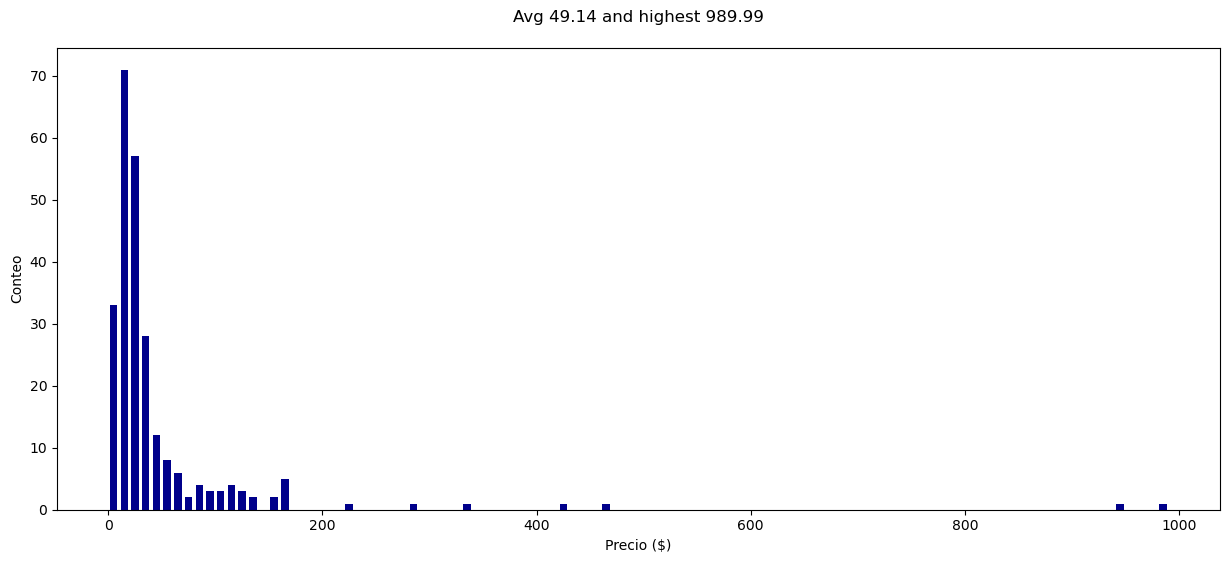

In [17]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Precio ($)')
plt.ylabel('Conteo')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

# Finalmente, cargue su nuevo conjunto de datos

Conviértalo en indicaciones y cárguelo en el centro de HuggingFace

In [18]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [19]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [20]:
DATASET_NAME = "joanby/lite-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/joanby/lite-data/commit/b0435bb63a661f0d79b7934797f32c13460876c4', commit_message='Upload dataset', commit_description='', oid='b0435bb63a661f0d79b7934797f32c13460876c4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/joanby/lite-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='joanby/lite-data'), pr_revision=None, pr_num=None)

In [21]:
# ¡Una cosa más!
# ¡Agreguemos los conjuntos de datos de entrenamiento y prueba para no tener que ejecutar todo este código la próxima vez!

with open('train_lite.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test_lite.pkl', 'wb') as file:
    pickle.dump(test, file)

## Tareas pendientes:

- ¡Investiga más el conjunto de datos!
- Confirma que el tokenizador convierte los precios de 3 dígitos en 1 token